# Code to Solve the Image Deblurring Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{S} \left( \boldsymbol{b} \circledast \boldsymbol{x} + \boldsymbol{\varepsilon} \right) = \boldsymbol{S} \left( \mathcal{C} (\boldsymbol{b})\boldsymbol{x} + \boldsymbol{\varepsilon} \right), \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{x} \in \mathbb{R}^{n}$: (vectorized) unknown image to recover 
- $\boldsymbol{b} \in \mathbb{R}^{n}$: (vectorized) blurring kernel
- $\mathcal{C}(\boldsymbol{b})$ : circulant matrix of $\boldsymbol{b}$
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{R}^{n}$: observed measurements
- $ \circledast : \mathbb{R}^{n} \times \mathbb{R}^{n} \mapsto \mathbb{R}^{n}$: denotes cicular convolution (https://en.wikipedia.org/wiki/Convolution)
- $ \boldsymbol{S} \in \mathbb{R}^{m} \times \mathbb{R}^{n}$: subsampling matrix

## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{x}}) = \frac{1}{2m} \| \boldsymbol{y} - \boldsymbol{S} \mathcal{C} (\boldsymbol{b})\boldsymbol{x} \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{x}) := \frac{1}{m} \sum_i^m \ell_{i}(\boldsymbol{x}) = \frac{1}{m}\sum_i^m \frac{1}{2}(y_i - \mathcal{C}_i(\boldsymbol{b}) \boldsymbol{x})^2$

- $\mathcal{C}_i(\boldsymbol{b})$ denotes the $i^{\text{th}}$ row of the circulant matrix of $\boldsymbol{b}$

### Full gradient:

$\nabla \ell ({\boldsymbol{x}}) = \frac{1}{m} \mathcal{C} (\boldsymbol{b})^\top \boldsymbol{S}^\top  ( \boldsymbol{S} \mathcal{C} (\boldsymbol{b}) \boldsymbol{x} - \boldsymbol{y} ) $

### Stochastic gradient:

$\nabla \ell_{i}({\boldsymbol{x}}) = \boldsymbol{S}^\top_i \mathcal{C} (\boldsymbol{b})^\top_i (\boldsymbol{x}^\top \mathcal{C}_i(\boldsymbol{b}) - y_i ) $



In [5]:
%matplotlib inline 

from imports import *
import pylops

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# No Subsampling --> Perfect Recovery?

/Users/vmonardo/Documents/Python/pnp-svrg/venv/lib/python3.9/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(256, 256)


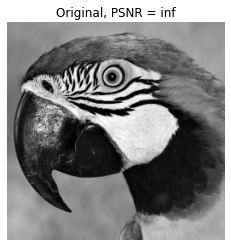

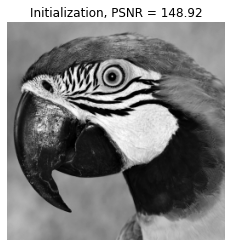

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

height = 256
width = 256

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./data/kernel.png', H=height, W=width, sigma=.0,  scale_percent=100, lr_decay=1.0)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
print(noisy.shape)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 255.5, 255.5, -0.5)

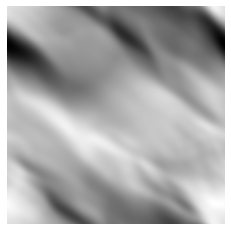

In [8]:
measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [9]:
denoiser = NLMDenoiser(filter_decay=0.99,
                       filter_size=0.000, patch_size=5, patch_distance=6, multichannel=True)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_gd(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=2.5e-11, tt=10, verbose=True)

0 Before denoising:  148.9172707637638
0 After denoising:  148.91727076189187
1 Before denoising:  148.9172707618919
1 After denoising:  148.91727076304974
2 Before denoising:  148.9172707630498
2 After denoising:  148.91727076382213
3 Before denoising:  148.91727076382216
3 After denoising:  148.91727076382216
4 Before denoising:  148.91727076382222
4 After denoising:  148.91727076382222
5 Before denoising:  148.91727076382227
5 After denoising:  148.91727076382227
6 Before denoising:  148.91727076382233
6 After denoising:  148.9172707638219
7 Before denoising:  148.91727076382196
7 After denoising:  148.91727076382193
8 Before denoising:  148.917270763822
8 After denoising:  148.91727076382242
9 Before denoising:  148.91727076382244
9 After denoising:  148.91727076382244
10 Before denoising:  148.9172707638225
10 After denoising:  148.91727076382207
11 Before denoising:  148.91727076382213
11 After denoising:  148.9172707638217
12 Before denoising:  148.91727076382176
12 After denois

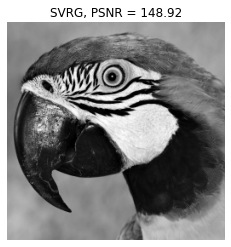

In [11]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=256, W=256)

(Compare with simply inverting/deblurring)

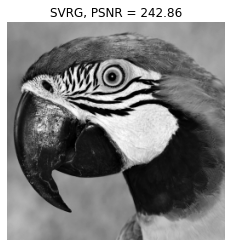

In [14]:
H, W = 256, 256
Y = fft_blur(problem.original, problem.blur)
Xhat = np.real(np.fft.ifft( np.fft.fft(problem.y.reshape(H,W).flatten())/np.fft.fft(problem.blur.flatten()) )).reshape(H,W) * H * W

psnr_display(img_path='./data/Set12/07.png', output=Xhat.reshape(problem.dim_old), title="SVRG", H=height, W=width)

# Only super resolution, no deblurring

/Users/vmonardo/Documents/Python/pnp-svrg/venv/lib/python3.9/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


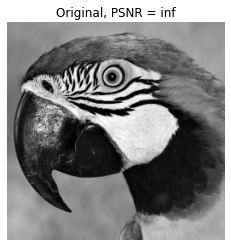

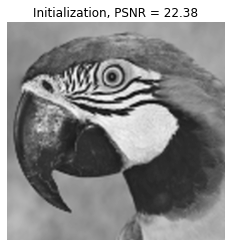

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

height = 256
width = 256
scaling = 50

problem = Deblur(img_path='./data/Set12/07.png', kernel="Identity", H=height, W=width, sigma=0., scale_percent=scaling, lr_decay=0.99)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min())
# print(noisy)

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 127.5, 127.5, -0.5)

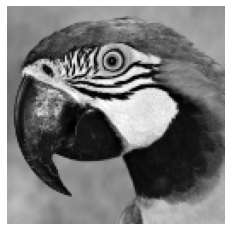

In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [23]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


denoiser = BM3DDenoiser(filter_decay=0.1, noise_est=0.1)
svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_gd(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=1e10, tt=60, verbose=True)

0 Before denoising:  27.420075815881056
0 After denoising:  26.736748688725083
1 Before denoising:  27.443126515501433
1 After denoising:  27.466298444923474
2 Before denoising:  27.543989092119222
2 After denoising:  27.544608163170675
3 Before denoising:  27.552015536855222
3 After denoising:  27.552021065283675
4 Before denoising:  27.55297602799954
4 After denoising:  27.552976040245056
5 Before denoising:  27.553044718424697
5 After denoising:  27.5530445526963
6 Before denoising:  27.552946068138183
6 After denoising:  27.552946055959584
7 Before denoising:  27.552799727705057
7 After denoising:  27.552799663328763
8 Before denoising:  27.55263779580816
8 After denoising:  27.552637514982603
9 Before denoising:  27.552479286261683
9 After denoising:  27.552479180781994
10 Before denoising:  27.55234191476598
10 After denoising:  27.552342025742295
11 Before denoising:  27.552241823746044
11 After denoising:  27.55224157380647
12 Before denoising:  27.552191743675202
12 After deno

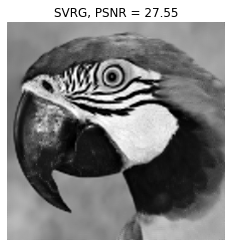

In [24]:
psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=height, W=width)

# Super resolution and deblurring

[[0.62344903 0.54830471 0.57064971 ... 0.56584104 0.53334173 0.5871427 ]
 [0.57122258 0.35961999 0.56047866 ... 0.59491009 0.41924676 0.63143225]
 [0.45246564 0.66713672 0.57081771 ... 0.4976797  0.52726709 0.561896  ]
 ...
 [0.49726512 0.73435122 0.59427796 ... 0.53063935 0.60554123 0.62357464]
 [0.57535086 0.55373006 0.53681386 ... 0.58945121 0.63434924 0.57566057]
 [0.58283597 0.54895771 0.51967118 ... 0.65227496 0.63359114 0.43001642]] 0.0 1.0
c:\Users\14807\Documents\GitHub\pnp-svrg\.venv\lib\site-packages\skimage\metrics\simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


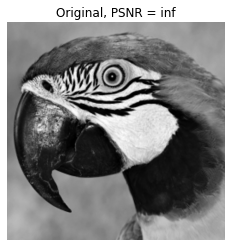

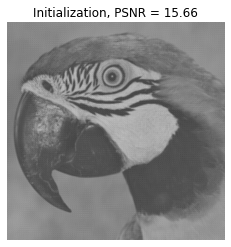

In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

height = 512
width = 512
scaling = 80

problem = Deblur(img_path='./data/Set12/07.png', kernel_path='./deblurring/kernel.png', H=height, W=width, sigma=0., scale_percent=scaling, lr_decay=1)
psnr_display(img_path='./data/Set12/07.png', output=problem.original, title="Original", H=height, W=width)

noisy = problem.noisy
noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min())
print(noisy, noisy.min(), noisy.max())

psnr_display(img_path='./data/Set12/07.png', output=noisy, title="Initialization", H=height, W=width)

(-0.5, 408.5, 408.5, -0.5)

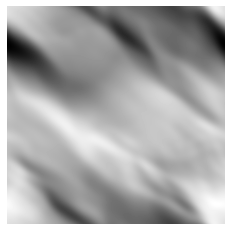

In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

measurements = problem.y
measurements = (measurements - measurements.min()) / (measurements.max() - measurements.min())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(measurements, cmap='gray', vmin=0, vmax=1)
ax.axis('off')

In [57]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

problem.noisy = noisy
denoiser = BM3DDenoiser(filter_decay=0.9, noise_est=0.1)
svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(problem=problem,
                                                   denoiser=denoiser,
                                                   eta=.5, tt=600, T2=10, mini_batch_size=np.floor(512*512/100).astype(int), verbose=True)                                           

After gradient update: 0 0 16.34652146009017
After denoising update: 0 0 16.898268750815955

After gradient update: 0 1 17.41599895108579
After denoising update: 0 1 17.553177474285803

After gradient update: 0 2 17.71680749360973
After denoising update: 0 2 17.74716793103114

After gradient update: 0 3 17.50403315867889
After denoising update: 0 3 17.501286145356048

After gradient update: 0 4 16.918309613778735
After denoising update: 0 4 16.90859712957144

After gradient update: 0 5 16.110904853929636
After denoising update: 0 5 16.101050929646302

After gradient update: 0 6 15.204063279816573
After denoising update: 0 6 15.196314060634235

After gradient update: 0 7 14.277509671371977
After denoising update: 0 7 14.271929660037934

After gradient update: 0 8 13.37329705400111
After denoising update: 0 8 13.369307805213822

After gradient update: 0 9 12.51165428543949
After denoising update: 0 9 12.509002951650556

After gradient update: 1 0 15.599294196445099
After denoising update

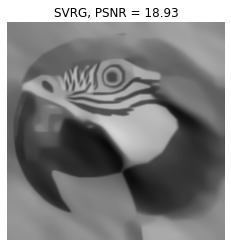

In [56]:
# print(svrg_out.reshape(height,width), svrg_out.reshape(height,width).min(), svrg_out.reshape(height,width).max())

psnr_display(img_path='./data/Set12/07.png', output=svrg_out.reshape(height,width), title="SVRG", H=512, W=512)